In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X = pd.read_csv('../input/housing-prices-competition-for-kaggle-learn-users/train.csv', index_col='Id') 
X_test = pd.read_csv('../input/housing-prices-competition-for-kaggle-learn-users/test.csv', index_col='Id')

print(X.shape)
print(X_test.shape)

#Q1: Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
print(X.shape)

#Q2: Separate target from predictors (i.e. input features)
y = X.SalePrice
X.drop(['SalePrice'], axis=1, inplace=True)

(1460, 80)
(1459, 79)
(1460, 80)


In [2]:
#Q3: Perform ordinal encoding to categorical feature columns 
from sklearn.preprocessing import OrdinalEncoder

# Get the columns that contain strings and treat them as categorical
object_cols = [col for col in X.columns if X[col].dtype == "object"]

# Columns that can be safely ordinal encoded
good_label_cols = [col for col in object_cols if 
                   set(X_test[col]).issubset(set(X[col]))]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))

print('Categorical columns that will be ordinal encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

# Drop categorical columns that will not be encoded
X_train_ordinal = X.drop(bad_label_cols, axis=1)
X_test_ordinal = X_test.drop(bad_label_cols, axis=1)

# Apply ordinal encoder 
ordinal_encoder = OrdinalEncoder() # Your code here
X_train_ordinal[good_label_cols] = ordinal_encoder.fit_transform(X_train_ordinal[good_label_cols])
X_test_ordinal[good_label_cols] = ordinal_encoder.transform(X_test_ordinal[good_label_cols])

#Q4: fill missing values in train and test sets using SimpleImputer
from sklearn.impute import SimpleImputer

final_imputer = SimpleImputer(strategy='median')

X_train_imputed = final_imputer.fit_transform(X_train_ordinal)
X_test_imputed = pd.DataFrame(final_imputer.transform(X_test_ordinal))
X_test_imputed.columns = X_test_ordinal.columns

Categorical columns that will be ordinal encoded: ['Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['SaleType', 'Exterior2nd', 'Functional', 'MSZoning', 'KitchenQual', 'Utilities', 'Exterior1st']


In [3]:
#Q5: XGBoost regressor train and test steps
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1, random_state=0)
model.fit(X_train_imputed, y)
preds_test = model.predict(X_test_imputed)

#Q6: Store the predictions as a pandas dataframe for submission
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)

Score: 14664.82491

In [4]:
#Q8: Iterative imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

iterative_imputer = IterativeImputer(max_iter=10)

X_train_iterative = iterative_imputer.fit_transform(X_train_ordinal)
X_test_iterative = pd.DataFrame(iterative_imputer.transform(X_test_ordinal))
X_test_iterative.columns = X_test_ordinal.columns

In [5]:
#Q8cont: Iterative imputer
from xgboost import XGBRegressor

model2 = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1, random_state=0)
model2.fit(X_train_iterative, y)
preds_test2 = model2.predict(X_test_iterative)


output2 = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test2})
output2.to_csv('submission2.csv', index=False)

Score: 14611.77751

In [6]:
#Q8: KNN imputer
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=3)

X_train_knn = knn_imputer.fit_transform(X_train_ordinal)
X_test_knn = pd.DataFrame(knn_imputer.transform(X_test_ordinal))
X_test_knn.columns = X_test_ordinal.columns

In [7]:
#Q8cont: KNN imputer
model3 = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1, random_state=0)
model3.fit(X_train_knn, y)
preds_test3 = model3.predict(X_test_knn)


output3 = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test3})
output3.to_csv('submission3.csv', index=False)

Score: 14826.62424

In [8]:
#Q9: Implementing function
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

def score_dataset(X_train,y):
    model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1, random_state=0)
    scores = -1 * cross_val_score(model,X_train, y,
                              cv=3,
                              scoring='neg_mean_absolute_error')
    return scores.mean()



Estimator size(max_iter): 1  		 Mean Absolute Error:  16587
Estimator size(max_iter): 3  		 Mean Absolute Error:  16587
Estimator size(max_iter): 5  		 Mean Absolute Error:  16587
Estimator size(max_iter): 7  		 Mean Absolute Error:  16587
Estimator size(max_iter): 9  		 Mean Absolute Error:  16587
Estimator size(max_iter): 11  		 Mean Absolute Error:  16587
Best max_iter size is: 1  		 Best Mean Absolute Error:  16587


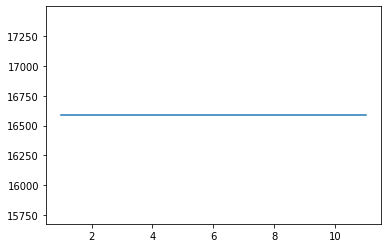

In [9]:
#Q10: 
candidate_max_iter = [1,3,5,7,9,11]

results = {}
small_iter_mae = 100000000
small_max_iter =0  
for estimators in candidate_max_iter:
    iter_imputer = IterativeImputer(max_iter=estimators)
    X_train_iterTest = iter_imputer.fit_transform(X_train_ordinal)
    my_mae =score_dataset(X_train_iterTest,y)
    results[estimators] = my_mae
    print("Estimator size(max_iter): %d  \t\t Mean Absolute Error:  %d" %(estimators, my_mae))
    if my_mae < small_iter_mae :
        small_max_iter = estimators
        small_iter_mae = my_mae


best_max_iter = small_max_iter
best_iter_mae = small_iter_mae 
print("Best max_iter size is: %d  \t\t Best Mean Absolute Error:  %d"%(best_max_iter,best_iter_mae))

import matplotlib.pyplot as plt     
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

Best max_iter size is: 1  		 Best Mean Absolute Error:  16587

Estimator size(n_neighbours): 1  		 Mean Absolute Error:  16244
Estimator size(n_neighbours): 3  		 Mean Absolute Error:  16265
Estimator size(n_neighbours): 5  		 Mean Absolute Error:  16335
Estimator size(n_neighbours): 7  		 Mean Absolute Error:  16210
Estimator size(n_neighbours): 9  		 Mean Absolute Error:  16377
Estimator size(n_neighbours): 11  		 Mean Absolute Error:  16396
Best n_neighbour size is: 7  		 Best Mean Absolute Error:  16210


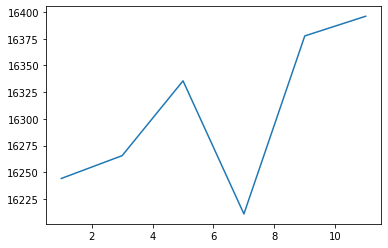

In [10]:
#Q11:
candidate_n_neighbours = [1,3,5,7,9,11]

knn_results = {}
small_knn_mae = 100000000
small_n_neighbours =0  
for estimators in candidate_n_neighbours:
    knn_imputer = KNNImputer(n_neighbors=estimators)
    X_train_knnTest = knn_imputer.fit_transform(X_train_ordinal)
    my_mae =score_dataset(X_train_knnTest,y)
    knn_results[estimators] = my_mae
    print("Estimator size(n_neighbours): %d  \t\t Mean Absolute Error:  %d" %(estimators, my_mae))
    if my_mae < small_knn_mae:
        small_n_neighbours = estimators
        small_knn_mae = my_mae

        
best_n_neighbours = small_n_neighbours
best_knn_mae = small_knn_mae
print("Best n_neighbour size is: %d  \t\t Best Mean Absolute Error:  %d"%(best_n_neighbours,best_knn_mae))

import matplotlib.pyplot as plt2
%matplotlib inline

plt2.plot(list(knn_results.keys()), list(knn_results.values()))
plt2.show()

Best n_neighbour size is: 7  		 Best Mean Absolute Error:  16210

In [11]:
#Q12:
iterative_imputer_final = IterativeImputer(max_iter=best_max_iter)

X_train_iter_final = iterative_imputer_final.fit_transform(X_train_ordinal)
X_test_iter_final = pd.DataFrame(iterative_imputer_final.transform(X_test_ordinal))
X_test_iter_final.columns = X_test_ordinal.columns

model_iter_final = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1, random_state=0)
model_iter_final.fit(X_train_iter_final, y)
preds_test_iter_final = model_iter_final.predict(X_test_iter_final)


output_iter_final = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test_iter_final})
output_iter_final.to_csv('submission_iter_final.csv', index=False)

Score: 14611.77751

In [12]:
#Q13:
knn_imputer_final = KNNImputer(n_neighbors=best_n_neighbours)

X_train_knn_final = knn_imputer_final.fit_transform(X_train_ordinal)
X_test_knn_final = pd.DataFrame(knn_imputer_final.transform(X_test_ordinal))
X_test_knn_final.columns = X_test_ordinal.columns

model_knn_final = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1, random_state=0)
model_knn_final.fit(X_train_knn_final, y)
preds_test_knn_final = model_knn_final.predict(X_test_knn_final)


output_knn_final = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test_knn_final})
output_knn_final.to_csv('submission_knn_final.csv', index=False)

Score: 14734.29326